In [1]:
import sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
sys.path.append('../../')
sys.path.append("/home/xinqiao/m3_learning/m3_learning/src")

In [2]:
# For the notebook to work you must have m3_learning installed
# pip install m3_learning
%load_ext autoreload
%autoreload 2 

In [3]:
from m3_learning.viz.printing import printer
from m3_learning.viz.style import set_style
from m3_learning.nn.Bright_Field_NN.Dataset import Bright_Field_Dataset
from m3_learning.nn.Bright_Field_NN.Viz import Viz
from m3_learning.viz.layout import layout_fig, labelfigs

# Specify the filename and the path to save the file
save_path = './../../../Data/2023_Bright_Field'
fig_path = save_path.replace("Data", "Figures") + '/'

# builds the printer object
printing = printer(basepath=fig_path,fileformats=['png'])

# Set the style of the plots
set_style("printing")

2023-06-15 11:20:51.990537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 11:20:52.154719: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-15 11:20:52.720056: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/xinqiao/anaconda3/envs/m3/lib/python3.9/site-packages/cv2/../../lib64:
2023-06-15 11:20:52.720131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'lib

printing set for seaborn


In [4]:
# defines Dataset object using images from specified folder
dset = Bright_Field_Dataset(f'{save_path}/Annealed','Annealed_results',verbose=False)

# list  paths to image data
# dset.list_imgs()

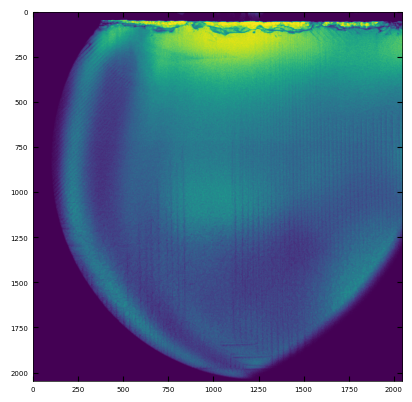

In [5]:
# extract array of image at rampdown, 50 deg celsius
im = dset.get_raw_img('Ramp_Down',"50")
plt.imshow(im)
plt.show()

In [6]:
# Write image data to h5 file
# dset.write_h5(200,300,1400,name='Anneal')

In [7]:
# customize window parameters
window_parameters = {'fft_mode': 'abs',
                    'mode': 'fft',
                    'window_size_x': 400,
                    'window_size_y': 400,
                    'window_step_x': 200,
                    'window_step_y': 200,
                    'zoom_factor': 2}

In [18]:
# customize window parameters
window_parameters = {'fft_mode': 'abs',
                    'mode': 'fft',
                    'window_size_x': 400,
                    'window_size_y': 400,
                    'window_step_x': 200,
                    'window_step_y': 200,
                    'zoom_factor': 2}

# Write windows
wins = dset.write_windows('Anneal',window_parms=window_parameters,overwrite=True)

100%|██████████| 43/43 [01:01<00:00,  1.43s/it]


## Visualization

In [9]:
# create vizualizer object
viz = Viz(dset,printer=printing)

# add scalebar
viz.scalebar_ = {"width": 273.4, "scale length": 50, "units": "nm"}


./../../../Figures/2023_Bright_Field/Ramp_Up_23_maps.png


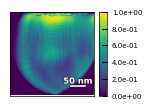

In [10]:

# view raw image
img_name = ['Ramp_Up','23']
viz.view_raw(img_name)

In [17]:
debug

> /home/xinqiao/m3_learning/m3_learning/papers/2023_the_effect_of_chemical_environment_and_temperature_on_the_domain_structure_of_freestanding_BaTiO3_via_in_situ_STEM/h5py/h5o.pyx(190)h5py.h5o.open()

> /home/xinqiao/m3_learning/m3_learning/papers/2023_the_effect_of_chemical_environment_and_temperature_on_the_domain_structure_of_freestanding_BaTiO3_via_in_situ_STEM/h5py/_objects.pyx(55)h5py._objects.with_phil.wrapper()

*** NameError: name 'grp' is not defined
> /home/xinqiao/m3_learning/m3_learning/papers/2023_the_effect_of_chemical_environment_and_temperature_on_the_domain_structure_of_freestanding_BaTiO3_via_in_situ_STEM/h5py/_objects.pyx(54)h5py._objects.with_phil.wrapper()

*** NameError: name 'grp' is not defined
> /home/xinqiao/anaconda3/envs/m3/lib/python3.9/site-packages/h5py/_hl/group.py(328)__getitem__()
    326                 raise ValueError("Invalid HDF5 object reference")
    327         elif isinstance(name, (bytes, str)):
--> 328             oid = h5o.open(self.id, se

KeyError: "Unable to open object (object 'windows' doesn't exist)"

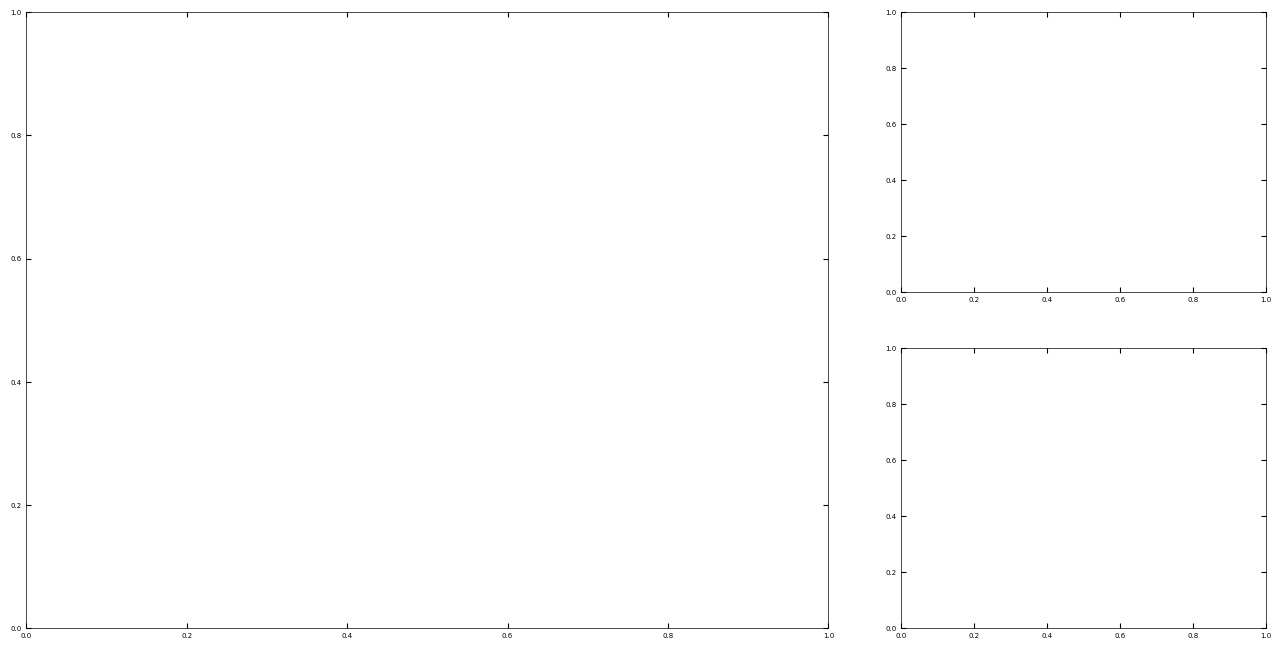

In [15]:
# view windows
viz.view_window(0,0,0,'Anneal','Ramp_up',
                window_parms=window_parameters)

In [67]:
h.close()